# Version 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

## I. Data Preparation / Handling

In [ ]:
# Load datasets
raw_industry_lfprgender = pd.read_csv('dataset1.csv') # Industry-Based Data w/ LFPR by Sex
df_industry_lfprgender = raw_industry_lfprgender.copy()

raw_industry = pd.read_csv('dataset2.csv')  # Industry-Based Data w/o LFPR by Sex
df_industry = raw_industry.copy()

raw_age = pd.read_csv('dataset3.csv')  # Age-Based Data
df_age = raw_age.copy()

###Data Cleaning and Preparation for industry-Based Data w/ LFPR by Sex

In [ ]:
# Create datetime column from YEAR and QUARTER, then drop them
quarter_map = {1: '01-01', 2: '04-01', 3: '07-01', 4: '10-01'}
df_industry_lfprgender['Date'] = pd.to_datetime(
    df_industry_lfprgender['YEAR'].astype(str) + '-' + df_industry_lfprgender['QUARTER'].map(quarter_map),
    format='%Y-%m-%d'
)
df_industry_lfprgender = df_industry_lfprgender.drop(['YEAR', 'QUARTER'], axis=1)

# Reorder columns to make Date the left-most
cols = ['Date'] + [col for col in df_industry_lfprgender.columns if col != 'Date']
df_industry_lfprgender = df_industry_lfprgender[cols]
df_industry_lfprgender

,Date,POST,TREAT,INDUSTRIES,WAGEGROWTH,GENDER,GDP,CPI,EMPLOYMENT,LFPR
0,2010-01-01,0,0,Financial and insurance,2.30,1,7.9,0.7,94.6,68.4
1,2010-01-01,0,1,Cleaner (general),-0.02,1,7.9,0.7,94.6,68.4
2,2010-01-01,0,1,Guard,1.54,1,7.9,0.7,94.6,68.4
3,2010-01-01,0,0,Financial and insurance,2.03,0,7.9,0.7,96.6,48.2
4,2010-01-01,0,1,Cleaner (general),0.78,0,7.9,0.7,96.6,48.2
...,...,...,...,...,...,...,...,...,...,...
91,2013-10-01,1,1,Cleaner (general),-0.77,1,2.9,2.4,96.5,68.8
92,2013-10-01,1,1,Guard,2.25,1,2.9,2.4,96.5,68.8
93,2013-10-01,1,0,Financial and insurance,-1.75,0,2.9,2.4,97.4,50.4
94,2013-10-01,1,1,Cleaner (general),1.11,0,2.9,2.4,97.4,50.4


In [ ]:
# Create lagged CPI and GDP
df_industry_lfprgender['CPI_lag'] = df_industry_lfprgender.groupby(['INDUSTRIES', 'GENDER'])['CPI'].shift(1)
df_industry_lfprgender['GDP_lag'] = df_industry_lfprgender.groupby(['INDUSTRIES', 'GENDER'])['GDP'].shift(1)

# Drop rows with NaN lagged variables (first quarter per group)
df_industry_lfprgender = df_industry_lfprgender.dropna(subset=['CPI_lag', 'GDP_lag'])

# Create interaction term for DiD
df_industry_lfprgender['Post_Treated'] = df_industry_lfprgender['POST'] * df_industry_lfprgender['TREAT']
df_industry_lfprgender

<ipython-input-4-d5914bf0b901>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_industry_lfprgender['Post_Treated'] = df_industry_lfprgender['POST'] * df_industry_lfprgender['TREAT']


,Date,POST,TREAT,INDUSTRIES,WAGEGROWTH,GENDER,GDP,CPI,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
6,2010-04-01,0,0,Financial and insurance,-1.04,1,6.4,-2.2,94.5,68.2,0.7,7.9,0
7,2010-04-01,0,1,Cleaner (general),3.63,1,6.4,-2.2,94.5,68.2,0.7,7.9,0
8,2010-04-01,0,1,Guard,-0.35,1,6.4,-2.2,94.5,68.2,0.7,7.9,0
9,2010-04-01,0,0,Financial and insurance,-0.78,0,6.4,-2.2,96.1,48.4,0.7,7.9,0
10,2010-04-01,0,1,Cleaner (general),0.62,0,6.4,-2.2,96.1,48.4,0.7,7.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2013-10-01,1,1,Cleaner (general),-0.77,1,2.9,2.4,96.5,68.8,2.1,3.1,1
92,2013-10-01,1,1,Guard,2.25,1,2.9,2.4,96.5,68.8,2.1,3.1,1
93,2013-10-01,1,0,Financial and insurance,-1.75,0,2.9,2.4,97.4,50.4,2.1,3.1,0
94,2013-10-01,1,1,Cleaner (general),1.11,0,2.9,2.4,97.4,50.4,2.1,3.1,1


###Data Cleaning and Preparation for industry-Based Data w/o LFPR by Sex


In [ ]:
# Create datetime column from YEAR and QUARTER, then drop them
quarter_map = {1: '01-01', 2: '04-01', 3: '07-01', 4: '10-01'}
df_industry['Date'] = pd.to_datetime(
    df_industry['YEAR'].astype(str) + '-' + df_industry['QUARTER'].map(quarter_map),
    format='%Y-%m-%d'
)
df_industry = df_industry.drop(['YEAR', 'QUARTER'], axis=1)

# Reorder columns to make Date the left-most
cols = ['Date'] + [col for col in df_industry.columns if col != 'Date']
df_industry = df_industry[cols]
df_industry

,Date,POST,TREAT,INDUSTRIES,WAGEGROWTH,GENDER,GDP,CPI,EMPLOYMENT,LFPR
0,2010-01-01,0,0,Financial and insurance,2.30,1,7.9,0.7,94.6,58.0
1,2010-01-01,0,1,Cleaner (general),-0.02,1,7.9,0.7,94.6,58.0
2,2010-01-01,0,1,Guard,1.54,1,7.9,0.7,94.6,58.0
3,2010-01-01,0,0,Financial and insurance,2.03,0,7.9,0.7,96.6,58.0
4,2010-01-01,0,1,Cleaner (general),0.78,0,7.9,0.7,96.6,58.0
...,...,...,...,...,...,...,...,...,...,...
91,2013-10-01,1,1,Cleaner (general),-0.77,1,2.9,2.4,96.5,59.2
92,2013-10-01,1,1,Guard,2.25,1,2.9,2.4,96.5,59.2
93,2013-10-01,1,0,Financial and insurance,-1.75,0,2.9,2.4,97.4,59.2
94,2013-10-01,1,1,Cleaner (general),1.11,0,2.9,2.4,97.4,59.2


In [ ]:
# Create lagged CPI and GDP
df_industry['CPI_lag'] = df_industry.groupby(['INDUSTRIES', 'GENDER'])['CPI'].shift(1)
df_industry['GDP_lag'] = df_industry.groupby(['INDUSTRIES', 'GENDER'])['GDP'].shift(1)

# Drop rows with NaN lagged variables (first quarter per group)
df_industry = df_industry.dropna(subset=['CPI_lag', 'GDP_lag'])

# Create interaction term for DiD
df_industry['Post_Treated'] = df_industry['POST'] * df_industry['TREAT']
df_industry

<ipython-input-6-02255f99600b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_industry['Post_Treated'] = df_industry['POST'] * df_industry['TREAT']


,Date,POST,TREAT,INDUSTRIES,WAGEGROWTH,GENDER,GDP,CPI,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
6,2010-04-01,0,0,Financial and insurance,-1.04,1,6.4,-2.2,94.5,57.9,0.7,7.9,0
7,2010-04-01,0,1,Cleaner (general),3.63,1,6.4,-2.2,94.5,57.9,0.7,7.9,0
8,2010-04-01,0,1,Guard,-0.35,1,6.4,-2.2,94.5,57.9,0.7,7.9,0
9,2010-04-01,0,0,Financial and insurance,-0.78,0,6.4,-2.2,96.1,57.9,0.7,7.9,0
10,2010-04-01,0,1,Cleaner (general),0.62,0,6.4,-2.2,96.1,57.9,0.7,7.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2013-10-01,1,1,Cleaner (general),-0.77,1,2.9,2.4,96.5,59.2,2.1,3.1,1
92,2013-10-01,1,1,Guard,2.25,1,2.9,2.4,96.5,59.2,2.1,3.1,1
93,2013-10-01,1,0,Financial and insurance,-1.75,0,2.9,2.4,97.4,59.2,2.1,3.1,0
94,2013-10-01,1,1,Cleaner (general),1.11,0,2.9,2.4,97.4,59.2,2.1,3.1,1


###Data Cleaning and Preparation for Age-Based Data

In [ ]:
# Impute missing EMPLOYMENT for AGE=10 (on the scaled-down data)
mean_emp_age10_female = df_age[(df_age['AGE'] == 10) & (df_age['GENDER'] == 1)]['EMPLOYMENT'].mean()
mean_emp_age10_male = df_age[(df_age['AGE'] == 10) & (df_age['GENDER'] == 0)]['EMPLOYMENT'].mean()
mean_emp_age10_overall = df_age[df_age['AGE'] == 10]['EMPLOYMENT'].mean()

# Impute missing values
df_age.loc[(df_age['AGE'] == 10) & (df_age['GENDER'] == 1) & (df_age['EMPLOYMENT'].isna()), 'EMPLOYMENT'] = mean_emp_age10_female
df_age.loc[(df_age['AGE'] == 10) & (df_age['GENDER'] == 0) & (df_age['EMPLOYMENT'].isna()), 'EMPLOYMENT'] = mean_emp_age10_overall

# Create datetime column from YEAR and QUARTER (uppercase column names)
quarter_map = {1: '01-01', 2: '04-01', 3: '07-01', 4: '10-01'}
df_age['Date'] = pd.to_datetime(
    df_age['YEAR'].astype(str) + '-' + df_age['QUARTER'].map(quarter_map),
    format='%Y-%m-%d'
)

# Drop YEAR and QUARTER (uppercase)
df_age = df_age.drop(['YEAR', 'QUARTER'], axis=1)

# Reorder columns to make Date the left-most
cols = ['Date'] + [col for col in df_age.columns if col != 'Date']
df_age = df_age[cols]

In [ ]:
# Define POST (pre-MWO: 2010-2011, post-MWO: 2012-2013)
df_age['POST'] = (df_age['Date'].dt.year >= 2012).astype(int)

# Exclude AGE 0-1, include only AGE 2-8 (treatment) and AGE 9-10 (control)
df_age = df_age[df_age['AGE'].isin([2, 3, 4, 5, 6, 7, 8, 9, 10])]

# Define TREAT: 0 for AGE 2-8 (25-59 years), 1 for AGE 9-10 (60 and over)
df_age['TREAT'] = (df_age['AGE'].isin([9, 10])).astype(int)

# Create lagged CPI & GDP
df_age['CPI_lag'] = df_age.groupby(['AGE', 'GENDER'])['CPI'].shift(1)
df_age['GDP_lag'] = df_age.groupby(['AGE', 'GENDER'])['GDP'].shift(1)

# Drop rows with NaN lagged variables (first quarter per group)
df_age = df_age.dropna(subset=['CPI_lag', 'GDP_lag'])

# Group by TREAT, GENDER, Date, and POST, and take the mean of EMPLOYMENT, LFPR, and CPI_lag
df_age_grouped = df_age.groupby(['TREAT', 'GENDER', 'Date', 'POST', 'AGE']).agg({
    'EMPLOYMENT': 'mean',
    'LFPR': 'mean',
    'CPI_lag': 'mean',
    'GDP_lag': 'mean'
}).reset_index()

# Create interaction term for DiD
df_age_grouped['Post_Treated'] = df_age_grouped['POST'] * df_age_grouped['TREAT']
df_age_grouped

,TREAT,GENDER,Date,POST,AGE,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
0,0,0,2010-04-01,0,2,96.6,82.6,0.7,7.9,0
1,0,0,2010-04-01,0,3,97.0,75.7,0.7,7.9,0
2,0,0,2010-04-01,0,4,97.1,68.6,0.7,7.9,0
3,0,0,2010-04-01,0,5,97.1,68.2,0.7,7.9,0
4,0,0,2010-04-01,0,6,96.2,64.6,0.7,7.9,0
...,...,...,...,...,...,...,...,...,...,...
265,1,1,2013-04-01,1,10,98.1,59.3,1.9,3.4,1
266,1,1,2013-07-01,1,9,97.2,56.7,0.8,3.1,1
267,1,1,2013-07-01,1,10,99.3,13.6,0.8,3.1,1
268,1,1,2013-10-01,1,9,97.5,55.0,2.1,3.1,1


## II. Data Visualisation

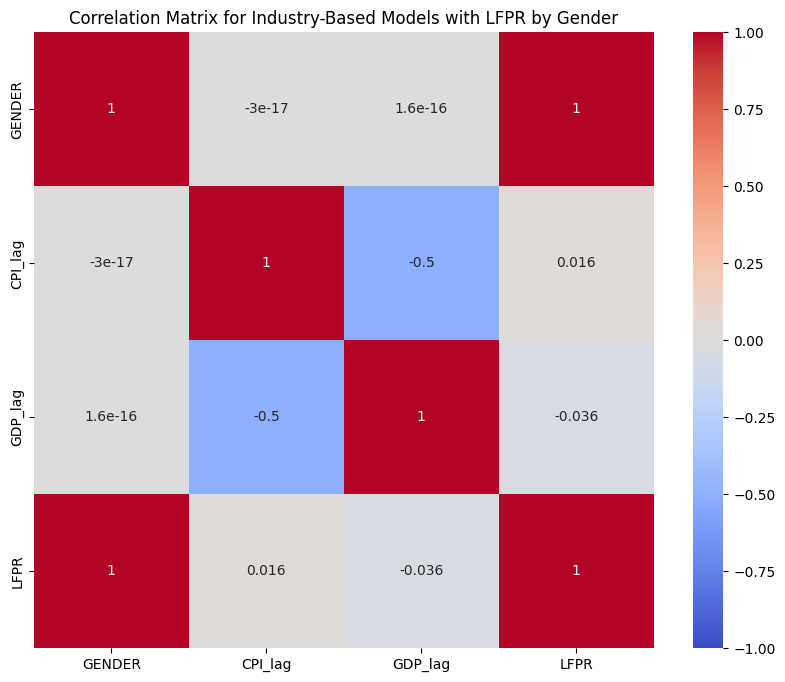

In [ ]:
# Multicollinearity Plot for df_industry
plt.figure(figsize=(10, 8))
correlation_matrix_industry_lfprgender = df_industry_lfprgender[['GENDER', 'CPI_lag', 'GDP_lag', 'LFPR']].corr() # 'POST', 'TREAT', 'Post_Treated'
sns.heatmap(correlation_matrix_industry_lfprgender, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Industry-Based Models with LFPR by Gender')
plt.show()

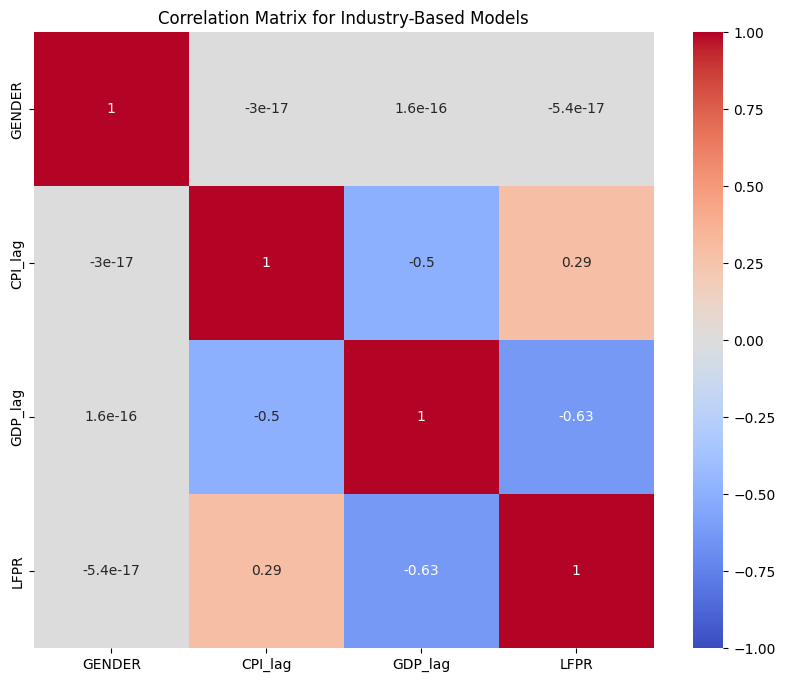

In [ ]:
# Multicollinearity Plot for df_industry
plt.figure(figsize=(10, 8))
correlation_matrix_industry = df_industry[['GENDER', 'CPI_lag', 'GDP_lag', 'LFPR']].corr() # 'POST', 'TREAT', 'Post_Treated'
sns.heatmap(correlation_matrix_industry, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Industry-Based Models')
plt.show()

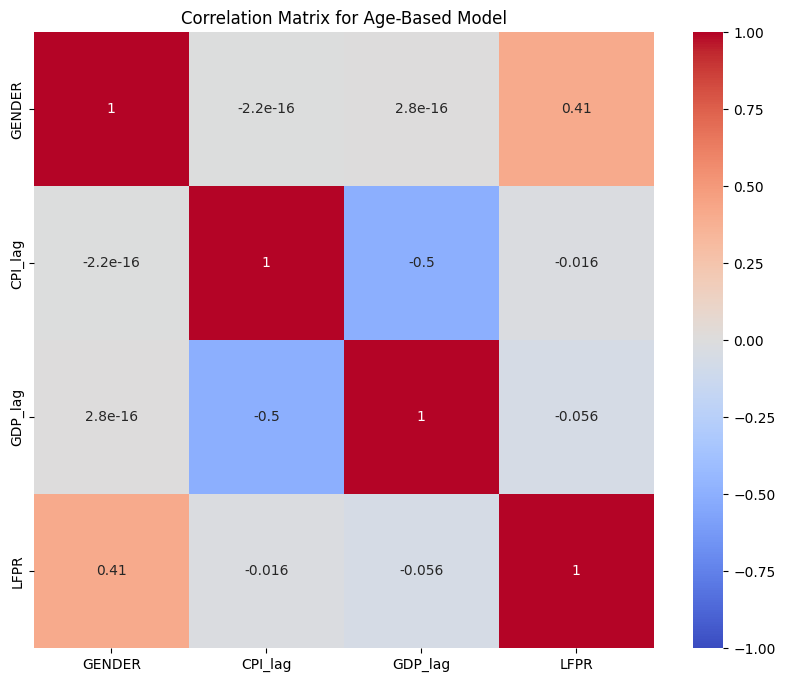

In [ ]:
# Multicollinearity Plot for df_age_grouped
plt.figure(figsize=(10, 8))
correlation_matrix_age = df_age_grouped[['GENDER', 'CPI_lag', 'GDP_lag', 'LFPR']].corr() # 'POST', 'TREAT', 'Post_Treated'
sns.heatmap(correlation_matrix_age, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Age-Based Model')
plt.show()

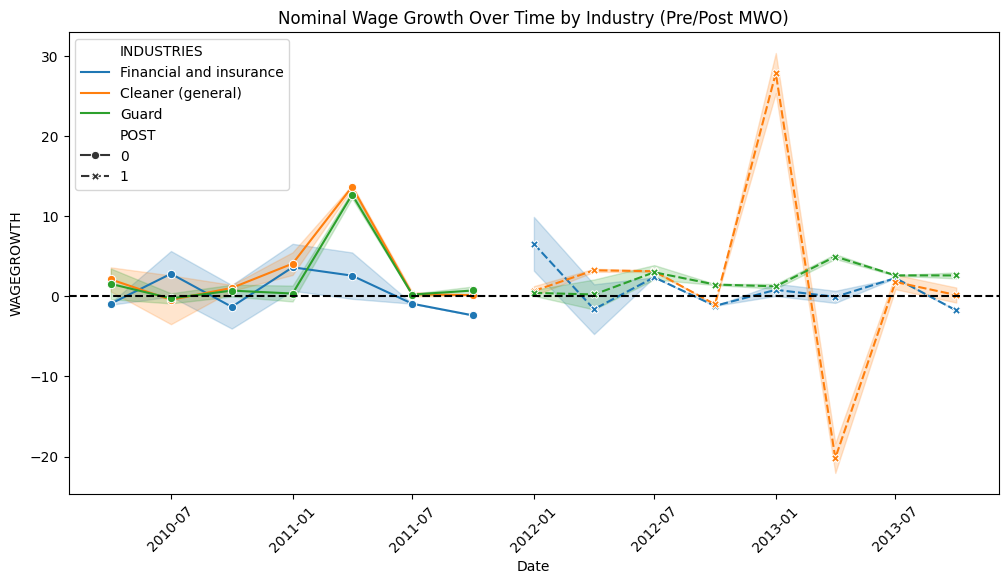

In [ ]:
# Additional Plot: Wage Growth Over Time by Industry
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_industry, x='Date', y='WAGEGROWTH', hue='INDUSTRIES', style='POST', markers=True)
plt.title('Nominal Wage Growth Over Time by Industry (Pre/Post MWO)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)

plt.show()

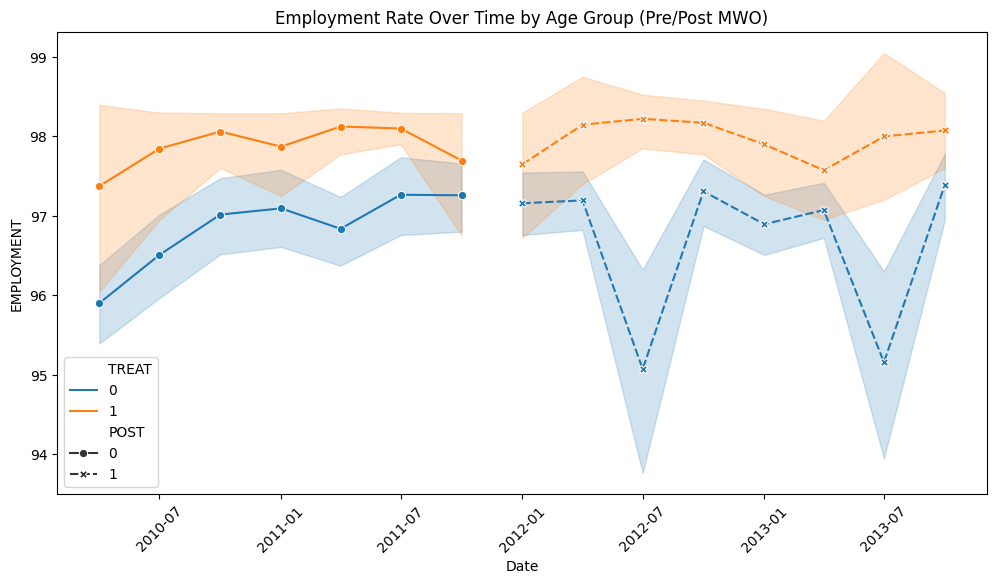

In [ ]:
# Additional Plot: Employment Rate by Age Group Over Time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_age, x='Date', y='EMPLOYMENT', hue='TREAT', style='POST', markers=True)
plt.title('Employment Rate Over Time by Age Group (Pre/Post MWO)')
plt.xticks(rotation=45)
plt.show()

## III. Regression Models

### A1. Nominal Wage Growth Model (Industry-Based Data) with combined industries

In [ ]:
#Nominal Wage Growth Model (dataset2)
model_wage = smf.ols(
    formula='WAGEGROWTH ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_industry
).fit(cov_type='HC3')

print("Nominal Wage Growth Model:")
print(model_wage.summary())

Nominal Wage Growth Model:
                            OLS Regression Results                            
Dep. Variable:             WAGEGROWTH   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.9953
Date:                Tue, 27 May 2025   Prob (F-statistic):              0.434
Time:                        11:47:07   Log-Likelihood:                -287.88
No. Observations:                  90   AIC:                             589.8
Df Residuals:                      83   BIC:                             607.3
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.54

### A2. Nominal Wage Growth Model (Industry-Based Data) with separated industries

In [ ]:
# Remove rows where INDUSTRIES = "Guard"
df_industry_cleaner = df_industry[df_industry['INDUSTRIES'] != 'Guard'].copy()
df_industry_cleaner.head()

,Date,POST,TREAT,INDUSTRIES,WAGEGROWTH,GENDER,GDP,CPI,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
6,2010-04-01,0,0,Financial and insurance,-1.04,1,6.4,-2.2,94.5,57.9,0.7,7.9,0
7,2010-04-01,0,1,Cleaner (general),3.63,1,6.4,-2.2,94.5,57.9,0.7,7.9,0
9,2010-04-01,0,0,Financial and insurance,-0.78,0,6.4,-2.2,96.1,57.9,0.7,7.9,0
10,2010-04-01,0,1,Cleaner (general),0.62,0,6.4,-2.2,96.1,57.9,0.7,7.9,0
12,2010-07-01,0,0,Financial and insurance,5.67,1,6.5,1.8,95.0,57.9,-2.2,6.4,0


In [ ]:
#Nominal Wage Growth Model (Cleaner)
model_wage = smf.ols(
    formula='WAGEGROWTH ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_industry_cleaner
).fit(cov_type='HC3')

print("Nominal Wage Growth Model (Cleaner):")
print(model_wage.summary())

Nominal Wage Growth Model (Cleaner):
                            OLS Regression Results                            
Dep. Variable:             WAGEGROWTH   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                 -0.058
Method:                 Least Squares   F-statistic:                    0.6165
Date:                Tue, 27 May 2025   Prob (F-statistic):              0.716
Time:                        11:47:07   Log-Likelihood:                -201.45
No. Observations:                  60   AIC:                             416.9
Df Residuals:                      53   BIC:                             431.6
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept  

In [ ]:
# Define TREAT specifically for the 'Security' industry
df_industry_guard = df_industry[df_industry['INDUSTRIES'] != 'Cleaner (general)'].copy()
df_industry_guard.head()

,Date,POST,TREAT,INDUSTRIES,WAGEGROWTH,GENDER,GDP,CPI,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
6,2010-04-01,0,0,Financial and insurance,-1.04,1,6.4,-2.2,94.5,57.9,0.7,7.9,0
8,2010-04-01,0,1,Guard,-0.35,1,6.4,-2.2,94.5,57.9,0.7,7.9,0
9,2010-04-01,0,0,Financial and insurance,-0.78,0,6.4,-2.2,96.1,57.9,0.7,7.9,0
11,2010-04-01,0,1,Guard,3.48,0,6.4,-2.2,96.1,57.9,0.7,7.9,0
12,2010-07-01,0,0,Financial and insurance,5.67,1,6.5,1.8,95.0,57.9,-2.2,6.4,0


In [ ]:
#Nominal Wage Growth Model (Security Guard)
model_wage = smf.ols(
    formula='WAGEGROWTH ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_industry_guard
).fit(cov_type='HC3')

print("Nominal Wage Growth Model (Security Guard):")
print(model_wage.summary())

Nominal Wage Growth Model (Security Guard):
                            OLS Regression Results                            
Dep. Variable:             WAGEGROWTH   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.543
Date:                Tue, 27 May 2025   Prob (F-statistic):            0.00505
Time:                        11:47:07   Log-Likelihood:                -150.76
No. Observations:                  60   AIC:                             315.5
Df Residuals:                      53   BIC:                             330.2
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Inte

###B. Employment Rate Model - Industry-Based with combined industries


In [ ]:
#Employment Rate Model - Industry-Based (dataset2)
model_emp_ind = smf.ols(
    formula='EMPLOYMENT ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_industry
).fit(cov_type='HC3')

print("\nEmployment Rate Model (Industry-Based):")
print(model_emp_ind.summary())


Employment Rate Model (Industry-Based):
                            OLS Regression Results                            
Dep. Variable:             EMPLOYMENT   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     54.73
Date:                Tue, 27 May 2025   Prob (F-statistic):           8.41e-27
Time:                        11:47:07   Log-Likelihood:                -26.025
No. Observations:                  90   AIC:                             66.05
Df Residuals:                      83   BIC:                             83.55
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Interce

###C1. Employment Rate Model - Age-Based (25-59 vs. 60+)


In [ ]:
#Employment Rate Model - Age-Based (dataset3)
model_emp_age = smf.ols(
    formula='EMPLOYMENT ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_age_grouped
).fit(cov_type='HC3')
print("\nEmployment DiD Model (Working-Age 25-59 vs. Older 60+):")
print(model_emp_age.summary())


Employment DiD Model (Working-Age 25-59 vs. Older 60+):
                            OLS Regression Results                            
Dep. Variable:             EMPLOYMENT   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     27.33
Date:                Tue, 27 May 2025   Prob (F-statistic):           2.96e-25
Time:                        11:47:07   Log-Likelihood:                -397.86
No. Observations:                 269   AIC:                             809.7
Df Residuals:                     262   BIC:                             834.9
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

###C2. Employment Rate Model - Age-Based (25-34 vs. 60+)

In [ ]:
# Filter for AGE 2-3 (25-34, control) and 9-10 (60+, treatment)
df_age_grouped_youth = df_age_grouped[df_age_grouped['AGE'].isin([2, 3, 9, 10])].copy()
df_age_grouped_youth

,TREAT,GENDER,Date,POST,AGE,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
0,0,0,2010-04-01,0,2,96.6,82.6,0.7,7.9,0
1,0,0,2010-04-01,0,3,97.0,75.7,0.7,7.9,0
7,0,0,2010-07-01,0,2,96.6,83.2,-2.2,6.4,0
8,0,0,2010-07-01,0,3,97.6,73.1,-2.2,6.4,0
14,0,0,2010-10-01,0,2,97.6,83.5,1.8,6.5,0
...,...,...,...,...,...,...,...,...,...,...
265,1,1,2013-04-01,1,10,98.1,59.3,1.9,3.4,1
266,1,1,2013-07-01,1,9,97.2,56.7,0.8,3.1,1
267,1,1,2013-07-01,1,10,99.3,13.6,0.8,3.1,1
268,1,1,2013-10-01,1,9,97.5,55.0,2.1,3.1,1


In [ ]:
#Employment Rate Model - Age-Based (Youth 25-34 vs. Older 60+)
model_emp_age = smf.ols(
    formula='EMPLOYMENT ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_age_grouped_youth
).fit(cov_type='HC3')
print("\nEmployment DiD Model (Youth 25-34 vs. Older 60+):")
print(model_emp_age.summary())


Employment DiD Model (Youth 25-34 vs. Older 60+):
                            OLS Regression Results                            
Dep. Variable:             EMPLOYMENT   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     10.52
Date:                Tue, 27 May 2025   Prob (F-statistic):           3.06e-09
Time:                        11:47:07   Log-Likelihood:                -177.70
No. Observations:                 119   AIC:                             369.4
Df Residuals:                     112   BIC:                             388.8
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

###C3. Employment Rate Model - Age-Based (35-44 vs. 60+)

In [ ]:
# Filter for AGE 4-5 (34-44, control) and 9-10 (60+, treatment)
df_age_grouped_mid = df_age_grouped[df_age_grouped['AGE'].isin([4, 5, 9, 10])].copy()
df_age_grouped_mid

,TREAT,GENDER,Date,POST,AGE,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
2,0,0,2010-04-01,0,4,97.1,68.6,0.7,7.9,0
3,0,0,2010-04-01,0,5,97.1,68.2,0.7,7.9,0
9,0,0,2010-07-01,0,4,98.0,68.2,-2.2,6.4,0
10,0,0,2010-07-01,0,5,97.5,66.9,-2.2,6.4,0
16,0,0,2010-10-01,0,4,97.6,67.9,1.8,6.5,0
...,...,...,...,...,...,...,...,...,...,...
265,1,1,2013-04-01,1,10,98.1,59.3,1.9,3.4,1
266,1,1,2013-07-01,1,9,97.2,56.7,0.8,3.1,1
267,1,1,2013-07-01,1,10,99.3,13.6,0.8,3.1,1
268,1,1,2013-10-01,1,9,97.5,55.0,2.1,3.1,1


In [ ]:
#Employment Rate Model - Age-Based (Middle Age 35-44 vs. Older 60+)
model_emp_age = smf.ols(
    formula='EMPLOYMENT ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_age_grouped_mid
).fit(cov_type='HC3')
print("\nEmployment DiD Model (Middle Age 35-44 vs. Older 60+):")
print(model_emp_age.summary())


Employment DiD Model (Middle Age 35-44 vs. Older 60+):
                            OLS Regression Results                            
Dep. Variable:             EMPLOYMENT   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     9.812
Date:                Tue, 27 May 2025   Prob (F-statistic):           1.12e-08
Time:                        11:47:07   Log-Likelihood:                -150.12
No. Observations:                 119   AIC:                             314.2
Df Residuals:                     112   BIC:                             333.7
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

###C4. Employment Rate Model - Age-Based (45-59 vs. 60+)

In [ ]:
# Filter for AGE 6-8 (45-59, control) and 9-10 (60+, treatment)
df_age_grouped_senior = df_age_grouped[df_age_grouped['AGE'].isin([6, 7, 8, 9, 10])].copy()
df_age_grouped_senior

,TREAT,GENDER,Date,POST,AGE,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
4,0,0,2010-04-01,0,6,96.2,64.6,0.7,7.9,0
5,0,0,2010-04-01,0,7,96.1,55.8,0.7,7.9,0
6,0,0,2010-04-01,0,8,96.5,39.2,0.7,7.9,0
11,0,0,2010-07-01,0,6,97.0,63.5,-2.2,6.4,0
12,0,0,2010-07-01,0,7,96.9,56.9,-2.2,6.4,0
...,...,...,...,...,...,...,...,...,...,...
265,1,1,2013-04-01,1,10,98.1,59.3,1.9,3.4,1
266,1,1,2013-07-01,1,9,97.2,56.7,0.8,3.1,1
267,1,1,2013-07-01,1,10,99.3,13.6,0.8,3.1,1
268,1,1,2013-10-01,1,9,97.5,55.0,2.1,3.1,1


In [ ]:
#Employment Rate Model - Age-Based (Senior 45-59 vs. Older 60+)
model_emp_age = smf.ols(
    formula='EMPLOYMENT ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_age_grouped_senior
).fit(cov_type='HC3')
print("\nEmployment DiD Model (Senior 45-59 vs. Older 60+):")
print(model_emp_age.summary())


Employment DiD Model (Senior 45-59 vs. Older 60+):
                            OLS Regression Results                            
Dep. Variable:             EMPLOYMENT   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     20.23
Date:                Tue, 27 May 2025   Prob (F-statistic):           5.16e-17
Time:                        11:47:08   Log-Likelihood:                -207.08
No. Observations:                 149   AIC:                             428.2
Df Residuals:                     142   BIC:                             449.2
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

### D. LFPR Model - Industry-Based

In [ ]:
df_industry_lfprgender.head()

,Date,POST,TREAT,INDUSTRIES,WAGEGROWTH,GENDER,GDP,CPI,EMPLOYMENT,LFPR,CPI_lag,GDP_lag,Post_Treated
6,2010-04-01,0,0,Financial and insurance,-1.04,1,6.4,-2.2,94.5,68.2,0.7,7.9,0
7,2010-04-01,0,1,Cleaner (general),3.63,1,6.4,-2.2,94.5,68.2,0.7,7.9,0
8,2010-04-01,0,1,Guard,-0.35,1,6.4,-2.2,94.5,68.2,0.7,7.9,0
9,2010-04-01,0,0,Financial and insurance,-0.78,0,6.4,-2.2,96.1,48.4,0.7,7.9,0
10,2010-04-01,0,1,Cleaner (general),0.62,0,6.4,-2.2,96.1,48.4,0.7,7.9,0


In [ ]:
# Labour Force Participation Rate Model - Industry-Based (dataset2)
model_lfpr_ind = smf.ols(
    formula='LFPR ~ POST + TREAT + Post_Treated + GENDER + CPI_lag + GDP_lag',
    data=df_industry_lfprgender
).fit(cov_type='HC3')

# Print results
print("\nLabour Force Participation Rate Model (Industry-Based):")
print(model_lfpr_ind.summary())


Labour Force Participation Rate Model (Industry-Based):
                            OLS Regression Results                            
Dep. Variable:                   LFPR   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     6763.
Date:                Tue, 27 May 2025   Prob (F-statistic):          2.11e-109
Time:                        11:47:08   Log-Likelihood:                -53.296
No. Observations:                  90   AIC:                             120.6
Df Residuals:                      83   BIC:                             138.1
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------